In [1]:
import random
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import PIL
import tqdm
from pathlib import Path
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

from sys import getsizeof

2024-05-06 08:37:41.328057: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 08:37:41.328151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 08:37:41.446766: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data_dir = "/kaggle/input/captchanumberdataset/captcha_number_dataset"

# Get list of all the images that end with .jpg
image_paths = sorted(list(glob.glob(f"{data_dir}/*.png")))
print(len(image_paths))
image_paths[0]

100000


'/kaggle/input/captchanumberdataset/captcha_number_dataset/00000.png'

In [4]:
def label_from_img_path(img_path):
    return os.path.splitext(os.path.basename(img_path))[0]

image_paths[230], label_from_img_path(image_paths[230])

('/kaggle/input/captchanumberdataset/captcha_number_dataset/00230.png',
 '00230')

In [5]:
labels = [label_from_img_path(img) for img in image_paths]
#checks which characters are in the dataset
characters = set(char for label in labels for char in label)
CHARACTERS = sorted(list(characters))

print("Number of images found: ", len(image_paths))
print("Random image: ", random.choice(image_paths))
print("Number of labels found: ", len(labels))
print("Random label: ", random.choice(labels))
print("sorted charecters set: ", CHARACTERS)
NUM_CHAR = len(CHARACTERS)
print("number of charecters: ", NUM_CHAR)

Number of images found:  100000
Random image:  /kaggle/input/captchanumberdataset/captcha_number_dataset/95312.png
Number of labels found:  100000
Random label:  23959
sorted charecters set:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
number of charecters:  10


In [6]:
# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

print ("the maximum length of any captcha", max_length)

# minimum length of any captcha in the dataset
min_length = min([len(label) for label in labels])

print ("the minimum length of any captcha", min_length)

if (max_length == min_length):
    print ("all the cpatchas are 5 letters long")
else:
    print ("the captchats are of diffrent length")
#now we know that all the cpatchas are 5 letters long

the maximum length of any captcha 5
the minimum length of any captcha 5
all the cpatchas are 5 letters long


In [7]:
CHAR_PER_LABEL = 5
label_char_count = np.array([len(label) for label in labels])
(label_char_count == CHAR_PER_LABEL).all()

True

In [8]:
def char_to_one_hot(char: str):
    out = np.zeros(len(CHARACTERS))
    idx = CHARACTERS.index(char)
    out[idx] = 1
    return out


def one_hot(characters: str):
    return np.hstack([char_to_one_hot(c) for c in characters]).astype('uint8')

In [11]:
assert len(char_to_one_hot('0')) == NUM_CHAR
assert char_to_one_hot('1').sum() == 1

test_string = '01234'
assert len(one_hot(test_string)) == NUM_CHAR * len(test_string)

In [12]:
def one_hot_to_char(x: np.array):
    y = np.array(x)
    y = y.squeeze()
    assert len(y) == NUM_CHAR
    idx = np.argmax(y)
    return(CHARACTERS[idx])


def one_hot_to_label(x):
    y = np.array(x)
    y = y.squeeze()
    label_list = []
    assert len(y) == len(CHARACTERS * CHAR_PER_LABEL)
    for i in range(0, CHAR_PER_LABEL):
        start = i * NUM_CHAR
        end = start + NUM_CHAR
        label_list.append(one_hot_to_char(y[start: end]))
    return "".join(label_list)

In [13]:
test_string = "34532"
assert one_hot_to_label(one_hot(test_string)) == test_string

## Data handling

In [14]:
images = [np.array(PIL.Image.open(img_path).convert('L')).astype('uint8') for img_path in tqdm.tqdm(image_paths)]
images_arr = np.array(images)
images_arr.shape

100%|██████████| 100000/100000 [06:47<00:00, 245.29it/s]


(100000, 40, 150)

In [15]:
labels_one_hot = np.array([one_hot(label) for label in tqdm.tqdm(labels)])
getsizeof(labels_one_hot)/1e6

100%|██████████| 100000/100000 [00:01<00:00, 59089.73it/s]


5.000128

In [16]:
getsizeof(images_arr)/1e6, getsizeof(labels_one_hot)/1e6

(600.000144, 5.000128)

In [17]:
from sklearn.model_selection import train_test_split

N = None

train_X, val_X, train_y, val_y = train_test_split(images_arr[:N, ...], labels_one_hot[:N, ...], test_size=0.2, random_state=12345)
train_X.shape, val_X.shape, train_y.shape, val_y.shape

((80000, 40, 150), (20000, 40, 150), (80000, 50), (20000, 50))

In [18]:
del images_arr
del labels_one_hot

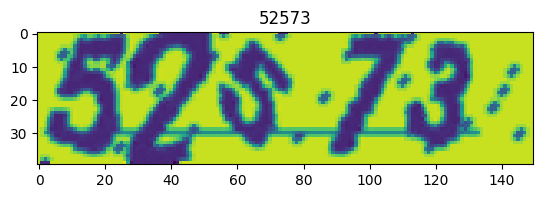

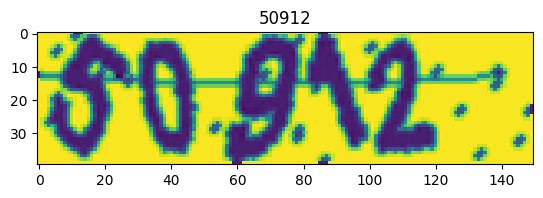

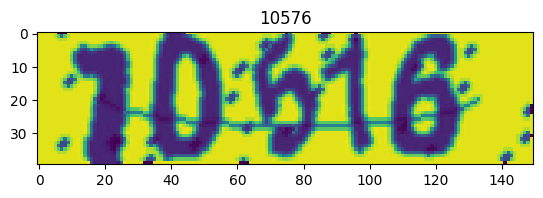

In [19]:
for i in [576, 1023, 536]:
    img = train_X[i, ...].squeeze()
    plt.figure()
    plt.imshow(img)
    plt.title(one_hot_to_label(train_y[i, ...].squeeze()))
plt.show()

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [22]:
def my_loss(y_true, y_pred):
    tot = 0.0
    for i in range(CHAR_PER_LABEL):
        start = i * NUM_CHAR
        end = start + NUM_CHAR
        tot += tf.nn.softmax_cross_entropy_with_logits(y_true[:, start:end], y_pred[:, start:end], axis=-1)
    return tot

def score_2(y_true, y_pred):
    hits = []
    for i in range(0, CHAR_PER_LABEL):
        start = i * NUM_CHAR
        end = start + NUM_CHAR
        idx = tf.math.argmax(y_pred[:, start:end], axis=1)
        hits.append([y_true[:, start:end][i, index] for i, index in enumerate(idx.numpy())])
    return tf.math.reduce_sum(tf.convert_to_tensor(hits), axis=0)/CHAR_PER_LABEL

def score_tf(y_true, y_pred):
    y_pred_mat = tf.reshape(y_pred, (-1, CHAR_PER_LABEL, NUM_CHAR))
    idx = tf.math.argmax(y_pred_mat, axis=-1)
    
    y_true_mat = tf.cast(tf.reshape(y_true, (-1, CHAR_PER_LABEL, NUM_CHAR)), 'float32')
    return tf.math.reduce_mean(tf.math.reduce_sum(tf.one_hot(idx, NUM_CHAR) * y_true_mat, axis=-1), axis=-1) 

def score_np(y_true, y_pred):
    y_pred_mat = np.reshape(y_pred, (-1, CHAR_PER_LABEL, NUM_CHAR))
    idx = y_pred_mat.argmax(axis=-1)
    
    y_true_mat = np.reshape(y_true, (-1, CHAR_PER_LABEL, NUM_CHAR))
    return (tf.one_hot(idx, NUM_CHAR).numpy() * y_true_mat).sum(axis=-1).mean(axis=-1) 

#test

s1 = "12345"
s2 = "23456"

sp1 = "34567"  # 2/5
sp2 = "45678"  # 5/5

y_true = np.vstack([one_hot(s1), one_hot(s2)])

# lets 
y_pred = np.vstack([one_hot(sp1), one_hot(sp2)])
y_pred = np.clip(y_pred + 0.0*np.random.rand(*y_pred.shape), 0, 1)
y_true_tf = tf.convert_to_tensor(y_true)
y_pred_tf = tf.convert_to_tensor(y_pred)
y_true_tf.shape, y_pred_tf.shape
my_loss(y_true_tf, y_pred_tf)
print("tensorflow", score_2(y_true_tf, y_pred_tf), score_tf(y_true_tf, y_pred_tf))
print("numpy", score_np(y_true, y_pred))

tensorflow tf.Tensor([0. 0.], shape=(2,), dtype=float32) tf.Tensor([0. 0.], shape=(2,), dtype=float32)
numpy [0. 0.]


In [23]:
from keras.callbacks import ReduceLROnPlateau

In [24]:
os.getcwd()
checkout_dir = 'model_checkout'
if checkout_dir not in os.listdir():
    os.mkdir('model_checkout')

In [27]:
model = tf.keras.models.Sequential([
    keras.Input(shape=(40, 150, 1)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(1, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.75),
    tf.keras.layers.Dense(len(CHARACTERS) * 5)
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 40, 150, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 40, 150, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 20, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 20, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 20, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 10, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 10, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 10, 37, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 5, 18, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 5, 18, 512)     │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 5, 18, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 23040)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 23040)          │        92,160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 23040)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    11,796,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │        25,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,470,514 (51.39 MB)

 Trainable params: 13,421,490 (51.20 MB)

 Non-trainable params: 49,024 (191.50 KB)

In [28]:
batch_size = 16

In [29]:
model_name = f"cnn_{model.count_params()}_params"

# Define the learning rate schedule
lr = 1e-3
lr_str = str(lr).replace(".", "")
learning_rate_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkout_dir + f'/{model_name}_batch_size_{batch_size}_init_lr_{lr_str}.weights.h5', save_best_only=True, save_weights_only=True)
# Compile and train your model
# run_eagerly=True is for score_2 to work
model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss=my_loss, metrics=['accuracy', score_tf])

In [30]:
# Train the model with the learning rate schedule
history = model.fit(
    train_datagen.flow(train_X[..., np.newaxis], train_y, batch_size=batch_size),
    epochs=60,
    batch_size=batch_size,
    validation_data=val_datagen.flow(val_X[..., np.newaxis], val_y, batch_size=batch_size),
    callbacks=[learning_rate_schedule, checkpoint]
    
)

Epoch 1/60


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   7/5000 ━━━━━━━━━━━━━━━━━━━━ 1:40 20ms/step - accuracy: 0.0068 - loss: 23.0537 - score_tf: 0.1186      

I0000 00:00:1714985536.697020     167 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714985536.720235     167 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4997/5000 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2702 - loss: 4.7719 - score_tf: 0.7399

W0000 00:00:1714985613.150109     167 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 100s 16ms/step - accuracy: 0.2702 - loss: 4.7699 - score_tf: 0.7400 - val_accuracy: 0.3238 - val_loss: 4.8674 - val_score_tf: 0.8498 - learning_rate: 0.0010
Epoch 2/60
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 81s 16ms/step - accuracy: 0.3783 - loss: 0.9853 - score_tf: 0.9409 - val_accuracy: 0.4316 - val_loss: 0.2702 - val_score_tf: 0.9846 - learning_rate: 0.0010
Epoch 3/60
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 81s 16ms/step - accuracy: 0.4131 - loss: 0.7047 - score_tf: 0.9580 - val_accuracy: 0.4880 - val_loss: 0.2297 - val_score_tf: 0.9878 - learning_rate: 0.0010
Epoch 4/60
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 80s 16ms/step - accuracy: 0.4166 - loss: 0.5437 - score_tf: 0.9677 - val_accuracy: 0.3495 - val_loss: 1.5851 - val_score_tf: 0.9162 - learning_rate: 0.0010
Epoch 5/60
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 80s 16ms/step - accuracy: 0.4116 - loss: 0.4248 - score_tf: 0.9748 - val_accuracy: 0.4624 - val_loss: 0.2981 - val_score_tf: 0.9873 - learning_rate: 0.0010
Epoch 6/60
5000/5000

In [41]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'score_tf', 'val_accuracy', 'val_loss', 'val_score_tf', 'learning_rate'])

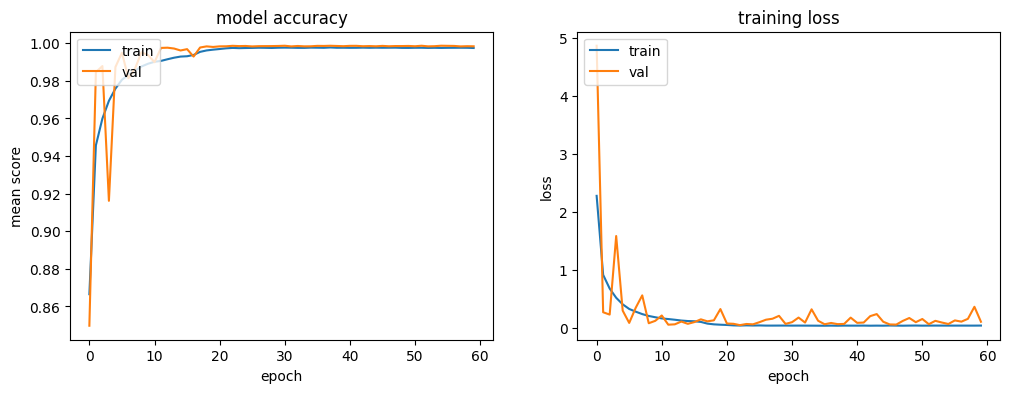

In [31]:
#Plot Results
_, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(history.history['score_tf'])
ax[0].plot(history.history['val_score_tf'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('mean score')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')


ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('training loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
71751


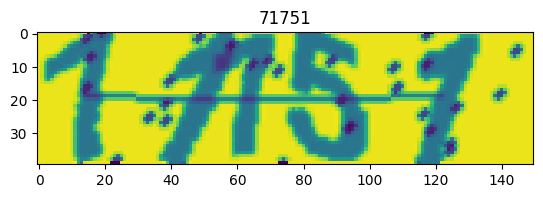

In [32]:
i = 0
y_pred = model.predict(val_X[0:1, ...]/255)

plt.figure()
plt.imshow(val_X[i, ...].squeeze())
plt.title(one_hot_to_label(val_y[i, ...].squeeze()))
print(one_hot_to_label(y_pred.squeeze()))

In [33]:
val_pred = model.predict(val_X/255)
print(val_pred.shape)

 35/625 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

W0000 00:00:1714990385.699405     167 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
(20000, 50)


In [34]:
scores = score_np(val_y, val_pred)

In [35]:
counts, bins = np.histogram(scores, bins=np.arange(0, 1.2, 0.2))

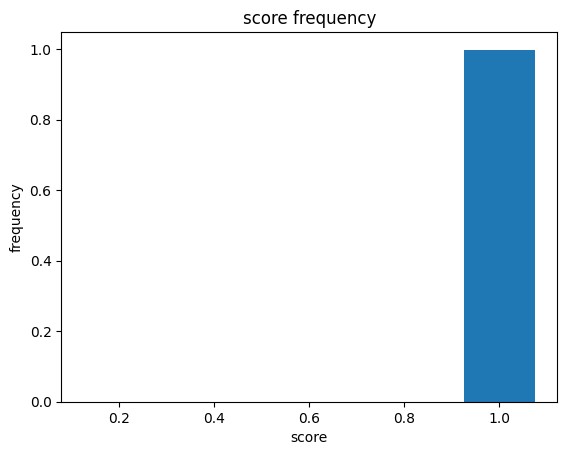

In [36]:
plt.bar(x=bins[1:], height=counts/counts.sum(), width=0.15)
plt.title("score frequency")
plt.ylabel("frequency")
plt.xlabel("score")
plt.show()

In [38]:
loaded_model = tf.keras.models.Sequential([
    keras.Input(shape=(40, 150, 1)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(1, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.75),
    tf.keras.layers.Dense(len(CHARACTERS) * 5)
])

weights_path = "/kaggle/working/model_checkout/cnn_13470514_params_batch_size_16_init_lr_0001.weights.h5"
loaded_model.load_weights(weights_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
71751


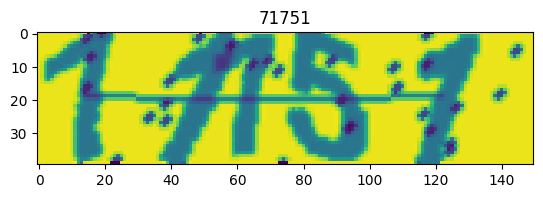

In [39]:
i = 0
y_pred = loaded_model.predict(val_X[0:1, ...]/255)

plt.figure()
plt.imshow(val_X[i, ...].squeeze())
plt.title(one_hot_to_label(val_y[i, ...].squeeze()))
print(one_hot_to_label(y_pred.squeeze()))